**Author:** C Mitchell

Here we want to look at the archive of discrete PIC measurements we have available to us and see how our uncertainty quantifications compare with these archived data

# Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
fulldf = pd.read_csv('data/03-PIC-blank-corrected.csv')
fulldf = fulldf.assign(label= fulldf.Code.str[:-1])
fulldf = fulldf.assign(culture_id = fulldf.label.str[0])
fulldf = fulldf.assign(treatment_id = fulldf.label.str[1:])

Pulling out only the data from the N culture

In [3]:
Ndf = fulldf.loc[fulldf['culture_id'] == 'N']

And defining the outliers (from previous analysis)

In [4]:
bx_outliers = [8, 9, 56]

# Quantifying the uncertainty using N culture

These next few cells are copied from the `06-N-culture-analysis` notebook

In [5]:
pic = Ndf['PIC ug/l']
pic_bx = pic[~pic.index.isin(bx_outliers)]
pic2 = Ndf['PIC mmol/m3']
pic2_bx = pic2[~pic2.index.isin(bx_outliers)]

In [6]:
def stats_dict(pic):

    madfn = lambda x: np.median(np.abs(x - np.median(x)))
    maefn = lambda x: np.mean(np.abs(x - np.mean(x)))
    biasfn = lambda x: np.median(x - np.median(x))
    biasfn_mn = lambda x: np.mean(x - np.mean(x))
   
    pic_stats = {'mean' : np.mean(pic),
                 'median' : np.median(pic),
                 'std' : np.std(pic),
                 'ste' : np.std(pic)/len(pic),
                 'mad' : madfn(pic),
                 'mae' : maefn(pic),
                 'bias' : biasfn(pic),
                 'bias_mean' : biasfn_mn(pic),
                'n' : len(pic)}
    
    return pic_stats

In [7]:
statsdf = pd.DataFrame({
 'PIC ug/l' : stats_dict(pic_bx), 
 'PIC mmol/m3' : stats_dict(pic2_bx)})

pd.options.display.float_format = '{:.4f}'.format

statsdf

,PIC ug/l,PIC mmol/m3
mean,0.0726,0.0061
median,0.1311,0.0109
std,0.2875,0.0240
ste,0.0288,0.0024
mad,0.1745,0.0145
mae,0.2414,0.0201
bias,0.0000,0.0000
bias_mean,0.0000,-0.0000
n,10.0000,10.0000


We want to report the standard deviation, MAE and MAD

# Comparison with the full discrete PIC dataset we have available

First let's import all the discrete PICs from our dataset

In [8]:
balchdbfile = '/mnt/storage/labs/mitchell/projects/pic-algorithm/pic-algorithm-dev-GH-repo-data/01-field-data/02b-discrete-formatted.csv'
balchdb = pd.read_csv(balchdbfile, low_memory=False, na_values = -999)

Pull out the PIC from the dataset and add in PIC data in mmol/m^3:

In [9]:
db_pic = pd.DataFrame({'PIC[ug/L]' : balchdb['PIC[ug/L]']})
db_pic['PIC[mmol/m3]'] = db_pic['PIC[ug/L]'] / 12

Compare dataset with the calculated MAE, MAD and standard deviation from the statsdf above:

In [10]:
p_std = np.sum(db_pic['PIC[mmol/m3]'] < statsdf.loc['std','PIC mmol/m3']) / len(db_pic) * 100
p_mad = np.sum(db_pic['PIC[mmol/m3]'] < statsdf.loc['mad','PIC mmol/m3']) / len(db_pic) * 100
p_mae = np.sum(db_pic['PIC[mmol/m3]'] < statsdf.loc['mae','PIC mmol/m3']) / len(db_pic) * 100

print('percentile of data below std: ' + str(p_std))
print('percentile of data below mad: ' + str(p_mad))
print('percentile of data below mae: ' + str(p_mae))

percentile of data below std: 10.818088223647738
percentile of data below mad: 8.711491248911063
percentile of data below mae: 10.176605686227925


## Make figure

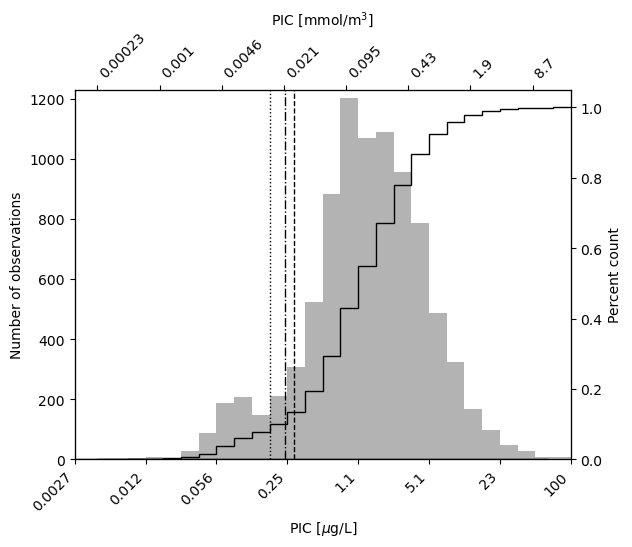

In [12]:
log_pic = np.log10((db_pic.loc[db_pic['PIC[mmol/m3]']>0, 'PIC[mmol/m3]'])*12)
log_pic.dropna(inplace=True)

pic_bins = np.linspace(log_pic.min(), log_pic.max(), 30)

tick_positions = pic_bins[::4]
tick_values = [10**tic for tic in tick_positions]
tick_labels = ['{:.2g}'.format(lab) for lab in tick_values]
tick_labels[-1] = '100'

fig,ax = plt.subplots()
ax.hist(log_pic, pic_bins,color=[0.7,0.7,0.7])
ax.set_xlim([tick_positions[0],tick_positions[-1]])

ax2 = ax.twinx()
ax2.hist(log_pic, pic_bins,density=True,cumulative=True,histtype='step',
        color='k',lw=1)
ax2.set_xlim([tick_positions[0],tick_positions[-1]])

ax.set_xlabel(r'PIC [$\mu$g/L]')
ax.set_ylabel('Number of observations')
ax2.set_ylabel('Percent count')
ax.set_xticks(tick_positions, tick_labels, rotation=45, ha='right')
plt.tick_params(direction='out')

ax3 = ax.twiny()
ax3.hist(log_pic/12, pic_bins,density=True,cumulative=True,histtype='step',
        color='k',lw=1.5);

tick_positions = pic_bins[::4]
tick_values = [(10**tic)/12 for tic in tick_positions]
tick_labels = ['{:.2g}'.format(lab) for lab in tick_values]
ax3.set_xticks(tick_positions, tick_labels, rotation=45, ha='left');
ax3.set_xlabel(r'PIC [mmol/m$^3$]');

std = statsdf.loc['std','PIC ug/l']
mad = statsdf.loc['mad','PIC ug/l']
mae = statsdf.loc['mae','PIC ug/l']
ax.plot([np.log10(std),np.log10(std)],[0,1250],'k--',lw=1)
ax.plot([np.log10(mad),np.log10(mad)],[0,1250],'k:',lw=1)
ax.plot([np.log10(mae),np.log10(mae)],[0,1250],'k-.',lw=1)
ax.set_ylim([0,1230])
plt.savefig('figures/Fig4-PIC-hist.png', dpi = 350, bbox_inches='tight')